<a href="https://colab.research.google.com/github/buikhanhhung/Detection-and-classification-of-bone-tumors-in-x-ray-ct-and-mri-images/blob/main/ADIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# nếu lưu dataset trên Google Drive
from google.colab import drive
drive.mount('/content/drive')

# cài những thư viện cần thiết
!pip install ultralytics pandas openpyxl scikit-learn shapely

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12

Giải nén

In [ ]:
ZIP_PATH = '/content/drive/MyDrive/dataset/BTXRD.zip'
DATA_DIR = '/content/drive/MyDrive/dataset/'      # sau giải nén
import os, zipfile
with zipfile.ZipFile(ZIP_PATH) as zf: zf.extractall(DATA_DIR)

Định nghĩa đường dẫn

In [ ]:
import os, json, shutil
import pandas as pd
from shapely.geometry import Polygon
from sklearn.model_selection import train_test_split


# nếu để trong Drive, ví dụ:
BASE_DATA = "/content/drive/MyDrive/dataset/BTXRD"

IMG_DIR      = os.path.join(BASE_DATA, "images")
ANN_DIR      = os.path.join(BASE_DATA, "Annotations")
META_XLSX    = os.path.join(BASE_DATA, "dataset.xlsx")
OUT_ROOT     = "/content/drive/MyDrive/dataset/processed"     # nơi sẽ chứa data đã convert

Đọc metadata và kiểm tra

In [ ]:
df = pd.read_excel(META_XLSX)
print("Các cột có trong metadata:", df.columns.tolist())
df.head()


Các cột có trong metadata: ['image_id', 'center', 'age', 'gender', 'hand', 'ulna', 'radius', 'humerus', 'foot', 'tibia', 'fibula', 'femur', 'hip bone', 'ankle-joint', 'knee-joint', 'hip-joint', 'wrist-joint', 'elbow-joint', 'shoulder-joint', 'tumor', 'benign', 'malignant', 'osteochondroma', 'multiple osteochondromas', 'simple bone cyst', 'giant cell tumor', 'osteofibroma', 'synovial osteochondroma', 'other bt', 'osteosarcoma', 'other mt', 'upper limb', 'lower limb', 'pelvis', 'frontal', 'lateral', 'oblique']


,image_id,center,age,gender,hand,ulna,radius,humerus,foot,tibia,...,synovial osteochondroma,other bt,osteosarcoma,other mt,upper limb,lower limb,pelvis,frontal,lateral,oblique
0,IMG000001.jpeg,1,48,F,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
1,IMG000002.jpeg,1,12,M,0,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0,0
2,IMG000003.jpeg,1,12,M,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
3,IMG000004.jpeg,1,52,M,0,0,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
4,IMG000005.jpeg,1,52,M,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1


Lọc ảnh vùng tay có u

In [ ]:
# chỉ lấy ảnh hand==1 và tumor==1 (có u để segment)
df_seg = df[(df["hand"]==1) & (df["tumor"]==1)].reset_index(drop=True)
print(f"Tổng ảnh segment: {len(df_seg)}")

# với classification binary, lấy tất cả ảnh hand==1
df_cls = df[df["hand"]==1].reset_index(drop=True)
print(f"Tổng ảnh cls: {len(df_cls)}")

Tổng ảnh segment: 97
Tổng ảnh cls: 97


Tạo cấu trúc thư mục

In [ ]:
# segmentation: 1 class "tumor"
# classification: 2 classes [benign, malignant]
for task in ["segment","cls"]:
    for split in ["train","val"]:
        for kind in ["images","labels"]:
            os.makedirs(f"{OUT_ROOT}/{task}/{split}/{kind}", exist_ok=True)

Chia train/val

In [ ]:
# 5.1 Split segmentation (stratify theo benign/malignant để cân bằng)
df_s_tr, df_s_va = train_test_split(
    df_seg, test_size=0.2,
    stratify=df_seg[["benign","malignant"]], random_state=42
)

# 5.2 Split classification (cân bằng benign/malignant)
df_c_tr, df_c_va = train_test_split(
    df_cls, test_size=0.2,
    stratify=df_cls[["benign","malignant"]], random_state=42
)


In [ ]:
def convert_segmentation(df_split, split):
    """
    Đọc JSON, lấy polygon shape làm mask,
    ghi file label YOLOv8-seg:
    <class> <x_center> <y_center> <w> <h> <seg_x1> <seg_y1> ...
    (tất cả chuẩn hóa [0–1])
    """
    for _, row in df_split.iterrows():
        img_id = row["image_id"]
        # copy image
        src_img = os.path.join(IMG_DIR, img_id)
        dst_img = os.path.join(OUT_ROOT, "segment", split, "images", img_id)
        shutil.copy(src_img, dst_img)

        # xây dựng tên file JSON đúng
        stem, _ = os.path.splitext(img_id)           # tách "IMG000001" và ".jpeg"
        json_name = f"{stem}.json"                  # thành "IMG000001.json"
        ann_path = os.path.join(ANN_DIR, json_name)

        # load JSON annotation
        if not os.path.exists(ann_path):
            raise FileNotFoundError(f"Không tìm thấy file annotation: {ann_path}")
        ann = json.load(open(ann_path))
        h, w = ann["imageHeight"], ann["imageWidth"]

        # tìm polygon shape (mask)
        for shape in ann["shapes"]:
            if shape["shape_type"] == "polygon":
                pts = shape["points"]
                # tính bbox của polygon
                poly = Polygon(pts)
                minx, miny, maxx, maxy = poly.bounds
                xc = (minx + maxx) / (2 * w)
                yc = (miny + maxy) / (2 * h)
                bw = (maxx - minx) / w
                bh = (maxy - miny) / h

                # flat polygon & chuẩn hóa
                seg_norm = []
                for x, y in pts:
                    seg_norm += [x / w, y / h]

                # ghi label
                lbl = os.path.join(
                    OUT_ROOT, "segment", split, "labels", f"{stem}.txt"
                )
                with open(lbl, "w") as f:
                    # 0 là class index cho "tumor"
                    parts = ["0", f"{xc:.6f}", f"{yc:.6f}", f"{bw:.6f}", f"{bh:.6f}"]
                    parts += [f"{v:.6f}" for v in seg_norm]
                    f.write(" ".join(parts))
                break  # nếu chỉ 1 mask/ảnh


In [ ]:
def convert_classification(df_split, split):
    """
    Copy image và ghi label nhị phân:
    <0|1> (0=benign,1=malignant)
    """
    for _, row in df_split.iterrows():
        img_id = row["image_id"]
        # copy ảnh
        shutil.copy(
          os.path.join(IMG_DIR, img_id),
          os.path.join(OUT_ROOT,"cls",split,"images",img_id)
        )
        # ghi label
        cls = int(row["malignant"])
        lbl = os.path.join(OUT_ROOT,"cls",split,"labels",
                           img_id.replace(".jpg",".txt"))
        with open(lbl,"w") as f:
            f.write(str(cls))

# thực thi conversion
convert_segmentation(df_s_tr, "train")
convert_segmentation(df_s_va, "val")

convert_classification(df_c_tr, "train")
convert_classification(df_c_va, "val")


In [ ]:
!yolo segment train \
    model=yolov8s-seg.pt \
    data=/content/drive/MyDrive/dataset/processed/segment/segment.yaml \
    epochs=100 \
    imgsz=640 \
    batch=8


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 22.8M/22.8M [00:00<00:00, 173MB/s]
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/drive/MyDrive/dataset/processed/segment/segment.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=

In [ ]:
!yolo classify train \
    model=yolov8s-cls.pt \
    data=/content/drive/MyDrive/dataset/processed/cls_imfolder \
    epochs=100 \
    imgsz=640 \
    batch=16 \
    project=/content/runs/cls2 \
    name=run1


Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolov8s-cls.pt, data=/content/drive/MyDrive/dataset/processed/cls_imfolder, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/runs/cls2, name=run16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

Processing: IMG001541.jpeg

image 1/1 /content/drive/MyDrive/dataset/processed/segment/train/images/IMG001541.jpeg: 640x640 benign 1.00, malignant 0.00, 853.9ms
Speed: 136.1ms preprocess, 853.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/dataset/processed/segment/train/images/IMG001541.jpeg: 640x544 3 tumors, 1187.2ms
Speed: 18.1ms preprocess, 1187.2ms inference, 49.3ms postprocess per image at shape (1, 3, 640, 544)
→ Saved: /content/drive/MyDrive/dataset/predictions/seg_masked/IMG001541.jpeg


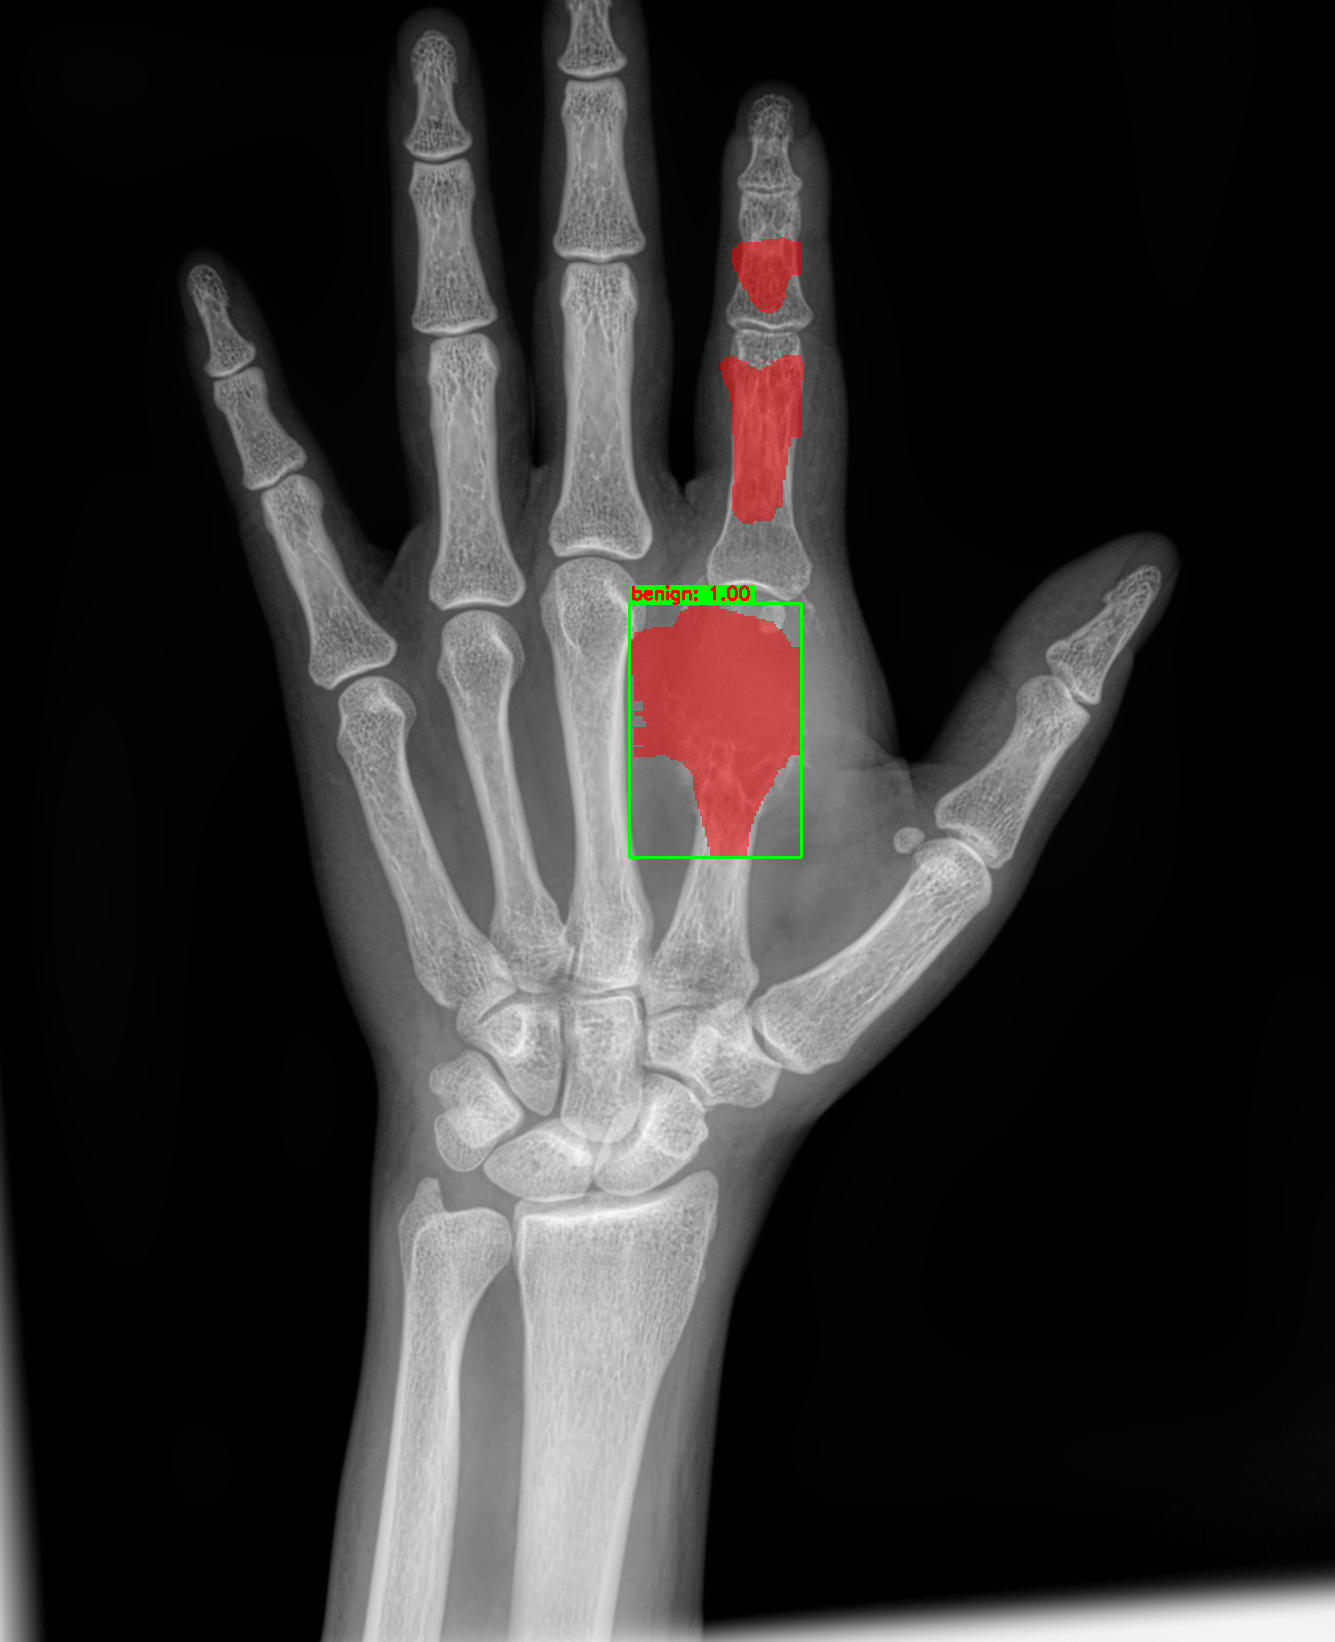


Processing: IMG001772.jpeg



FileNotFoundError: /content/drive/MyDrive/dataset/processed/cls_imfolder/train/malignant/IMG001772.jpeg does not exist

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import os
from PIL import Image
from IPython.display import display

# 1. Đường dẫn weights đã train
CLS_WEIGHTS = '/content/drive/MyDrive/runs/cls2/run16/weights/best.pt'
SEG_WEIGHTS = '/content/drive/MyDrive/runs/segment/train/weights/best.pt'

# 2. Load model
cls_model = YOLO(CLS_WEIGHTS)
seg_model = YOLO(SEG_WEIGHTS)

# 3. Danh sách ảnh cần dự đoán
img_paths = [
    '/content/drive/MyDrive/dataset/processed/segment/train/images/IMG001541.jpeg',
    '/content/drive/MyDrive/dataset/processed/cls_imfolder/train/malignant/IMG001772.jpeg',
]

# 4. Thư mục lưu kết quả
OUT_DIR = '/content/drive/MyDrive/dataset/predictions'
SEG_OUT = os.path.join(OUT_DIR, 'seg_masked')
os.makedirs(SEG_OUT, exist_ok=True)

# 5. Font cho OpenCV
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.6
font_thick = 2

# 6. Màu sắc
mask_color = np.array([0, 0, 255], dtype=np.uint8)  # đỏ BGR
box_color  = (0, 255, 0)                           # xanh BGR
text_color = (0, 0, 255)                           # đỏ BGR

for img_path in img_paths:
    print('\nProcessing:', os.path.basename(img_path))

    # Classification để lấy label
    cls_res = cls_model.predict(source=img_path, conf=0.9, save=False)[0]
    cid   = int(cls_res.probs.top1)
    cname = cls_res.names[cid]
    cconf = float(cls_res.probs.top1conf)
    label = f"{cname}: {cconf:.2f}"

    # Segmentation
    seg_res = seg_model.predict(source=img_path, conf=0.1, save=False)[0]
    orig = cv2.imread(img_path)
    h, w = orig.shape[:2]
    overlay = orig.copy()

    # Chỉ khi có mask thì vẽ
    if seg_res.masks is not None and len(seg_res.masks.data) > 0:
        # 1. Gộp mask và overlay
        combined = np.zeros((h, w), dtype=np.uint8)
        for mask in seg_res.masks.data:
            m_np = mask.cpu().numpy()
            m_rs = cv2.resize(m_np, (w, h), interpolation=cv2.INTER_NEAREST) > 0.5
            combined[m_rs] = 255
            bg = orig[m_rs].astype(float)
            fg = np.tile(mask_color, (bg.shape[0],1)).astype(float)
            overlay[m_rs] = (0.5*bg + 0.5*fg).astype(np.uint8)

        # 2. Tìm contour lớn nhất, vẽ bounding box
        cnts, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        c = max(cnts, key=cv2.contourArea)
        x,y,bw,bh = cv2.boundingRect(c)
        cv2.rectangle(overlay, (x,y), (x+bw, y+bh), box_color, 2)

        # 3. Vẽ nhãn classification tại góc trái box
        ts, _ = cv2.getTextSize(label, font, font_scale, font_thick)
        tw, th = ts
        # nền text
        cv2.rectangle(overlay, (x, y-th-4), (x+tw+4, y), box_color, cv2.FILLED)
        cv2.putText(overlay, label, (x+2, y-4), font, font_scale, text_color, font_thick)

    else:
        print("→ No masks detected, skipping segmentation overlay & box.")

    # Lưu & hiển thị
    out_path = os.path.join(SEG_OUT, os.path.basename(img_path))
    cv2.imwrite(out_path, overlay)
    print("→ Saved:", out_path)
    display(Image.fromarray(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)))
